<!-- <img align="left" style="padding-right:30px;" src="./Images/logo_UNSW.svg" height="100"><img align="left" style="padding-right:30px;" src="./Images/Green_RGB.png" height="90"><img align="left" style="padding-right:30px;" src="./Images/image004.png" height="100">
 -->

[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **<div style="text-align: left; font-size: 30px;"> Pathways to global hydrogen production within planetary boundaries**</div>
**<div style="text-align: left; font-size: 25px;"> Life cycle optimisation - Tutorial**</div>

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Section for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>


# **Target audience & prerequisites**

> <span style="color:rgba(22, 210, 69, 1); font-weight: bold;">Target audience</span><br>
>- Life cycle assessment practioners/researchers
>- Absolute environmental sustainability practioners/researchers

> <span style="color:rgba(191, 200, 30, 1); font-weight: bold;">Prerequisites</span><br>
>- Background in life cycle assessment
>- Brightway
>- Activity browser (with ScenarioLink installed)
>- Julia with JuMP.jl
>- CPLEX optimisation solver
>- IDE (e.g., VS code)

# **Intro to AESA**

<div style="text-align:center;">
  <img src="./Images/framwork2.svg">
</div>

<!-- # Contents <span style="color:rgba(0, 0, 0, 1); font-weight: bold;">Contents</span><br> -->
# **Contents**

>1. Background information on computational LCA and optimisation
>2. Installation of planetary boundaries characterisation factors
>3. Modelling aggregated inventories on Activity - browser
>4. pre-optimisation formating on Excel
>5. Implementation of the optimisation model in Julia using JuMP.jl


# **Case study**

<!-- > <span style="color:rgba(184, 193, 29, 1); font-weight: bold;">Simple optimisation example</span><br>
>- Optimisation of electrical mix for hydrogen production via PEM electrolysis
>- Using activity browser, excel and Julia (a python version is also possible)
>- Integration of prospective LCA data in the optimisation.
>- Optional - Cost and material tracking -->


> <span style="color:rgba(26, 190, 67, 1); font-weight: bold;">Goal  & Scope definition</span><br>
>- Goal: Minimising the effective planetary footprint of hydrogen production via PEM electrolysis.
>- LCA type: prospective attributional LCA (note that the appraoch can also be interpreted as consequential)
>- Functional unit: 225 MtH₂/year (2050) (global annual production of H₂ via water electrolysis)
>- Scope: Cradle to gate (electricity production + PEM electrolysis)
>- Database: ecoinvent 3.9.1 (cut-off) - updated with premise - SSP1-PkBudg500
<div style="text-align:center;">
  <img src="./Images//PEM_unit1.svg">
</div>


### **Initialisation**

In [550]:
using JuMP, CPLEX,Distributions,DataFrames,LinearAlgebra,XLSX
using PyPlot
using SparseArrays
using JLD2
PyPlot.svg(true)
using lce
initProject("Natcoms")
⊘ = ./;



┌ Info: Project Natcoms -> model:ecoinvent_3.9.1 RCP:0.0 SSP:0 year:0 loaded
└ @ lce /Users/mickael/Library/CloudStorage/OneDrive-UNSW/Research/Publications/Journal articles/1_Natcoms/code/lce/src/lce.jl:781


# **Data import**

In [10]:
aSOS = XLSX.readtable("./data/Fig2c.xlsx", "allocated SOS") |> DataFrame # %SOS/GtH2/yr



Row,Year,SOS_per_GtH2_05,SOS_per_GtH2_25,SOS_per_GtH2_50,SOS_per_GtH2_75,SOS_per_GtH2_95
,Any,Any,Any,Any,Any,Any
1,2025.0,6.73849,8.91468,9.53045,13.0886,13.7765
2,2030.0,4.29387,5.98068,7.23146,9.79054,12.4713
3,2035.0,2.40314,3.25648,4.07245,7.64923,9.58434
4,2040.0,1.50013,1.98989,2.65428,4.63441,7.64559
5,2045.0,1.07436,1.51761,2.13706,2.69473,6.52992
6,2050.0,0.761957,1.18881,1.59743,2.49928,5.57836


In [11]:
𝚪ᵦ=XLSX.readtable("./data/interactions_matrices.xlsx", "𝚪ᵦ") |> DataFrame



Row,Climate change Energy imbalance,Climate change CO2 Concentration,Ocean acidification,Atmospheric aerosol loading,Freshwater use,Biogeochemical flows-P,Biogeochemical flows-N,Stratospheric ozone depletion,Land-system change,Biosphere Integrity
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,1.22241,0,-0.0100732,0.0232257,-0.111239,0.232257,0.232257,-0.0710218,0.122241,0.38386
2,0,1.22241,-0.0100732,0.0232257,-0.111239,0.232257,0.232257,-0.0710218,0.122241,0.38386
3,0.325108,0,1.06115,0.00617706,-0.0295849,0.0617706,0.0617706,-0.0188888,0.0325108,0.4567
4,-0.684548,0,0.00564097,0.986994,0.0622939,-0.130064,-0.130064,0.0397722,-0.0684548,-0.214962
5,0.220814,0,0.0407336,0.00419546,0.979906,0.0419546,0.0419546,-0.0128293,0.0220814,0.416858
6,0.206199,0,0.0138327,0.103918,-0.0187641,1.03918,1.03918,-0.00198018,0.0206199,0.426595
7,0.206199,0,0.0138327,0.103918,-0.0187641,1.03918,1.03918,-0.00198018,0.0206199,0.426595
8,-0.134465,0,0.00110805,-0.00255483,0.0122363,-0.0255483,-0.0255483,1.00781,-0.0134465,-0.0422246
9,0.428032,0,0.233494,0.00813261,-0.148951,0.0813261,0.0813261,-0.0248687,1.0428,0.470084


In [12]:
𝚪=Matrix{Float64}(𝚪ᵦ)


10×10 Matrix{Float64}:
  1.22241   0.0      -0.0100732   …  -0.0710218    0.122241    0.38386
  0.0       1.22241  -0.0100732      -0.0710218    0.122241    0.38386
  0.325108  0.0       1.06115        -0.0188888    0.0325108   0.4567
 -0.684548  0.0       0.00564097      0.0397722   -0.0684548  -0.214962
  0.220814  0.0       0.0407336      -0.0128293    0.0220814   0.416858
  0.206199  0.0       0.0138327   …  -0.00198018   0.0206199   0.426595
  0.206199  0.0       0.0138327      -0.00198018   0.0206199   0.426595
 -0.134465  0.0       0.00110805      1.00781     -0.0134465  -0.0422246
  0.428032  0.0       0.233494       -0.0248687    1.0428      0.470084
  0.718619  0.0       0.185568       -0.0417518    0.0718619   1.28949

In [13]:
SOS = XLSX.readtable("./data/SOS.xlsx", "Planetary boundaries") |> DataFrame


Row,Control variable,Pre-industrial value,Planetary boundary,SOS,High risk,High risk space,Units
,Any,Any,Any,Any,Any,Any,Any
1,Climate change-Energy imbalance,0.0,1.0,1.0,1.5,1.5,W/m2
2,Climate change-CO2 Concentration,278.0,350.0,72.0,450.0,172.0,ppm
3,Ocean acidification-Carbonate ion concentration,3.44,2.752,0.688,2.408,1.032,Ωarag
4,Atmospheric aerosol loading-Aerosol Optical Depth (AOD),0.03,0.1,0.07,0.25,0.22,Aerosol optical depth
5,Freshwater use-Global,0.0,4000.0,4000.0,6000.0,6000.0,km3
6,Biogeochemical flows-P,0.0,11.0,11.0,100.0,100.0,TgP
7,Biogeochemical flows-N,0.0,62.0,62.0,82.0,82.0,TgN
8,Stratospheric ozone depletion-Stratospheric O3 concentration,290.0,276.0,14.0,261.0,29.0,Dobson units
9,Land-system change-Global,100.0,75.0,25.0,54.0,46.0,%


Safe operaring space 

In [14]:
categories=SOS[:,1]


10-element Vector{Any}:
 "Climate change-Energy imbalance"
 "Climate change-CO2 Concentration"
 "Ocean acidification-Carbonate ion concentration"
 "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)"
 "Freshwater use-Global"
 "Biogeochemical flows-P"
 "Biogeochemical flows-N"
 "Stratospheric ozone depletion-Stratospheric O3 concentration"
 "Land-system change-Global"
 "Biosphere Integrity-Change in biosphere integrity"

In [15]:
Δ𝐗ᴾᴮ=SOS[:,4]


10-element Vector{Any}:
    1.0
   72.0
    0.6880000000000002
    0.07
 4000.0
   11.0
   62.0
   14.0
   25.0
   10.0

In [16]:
units=SOS[:,end]


10-element Vector{Any}:
 "W/m2"
 "ppm"
 "Ωarag"
 "Aerosol optical depth"
 "km3"
 "TgP"
 "TgN"
 "Dobson units"
 "%"
 "%"

# **Allocation factor**

We want to express it in an allocation factor per kg of H2 produced.

In [17]:
α=aSOS[1,4] #%SOS/GtH2 (median value)
ω°=α/100*Δ𝐗ᴾᴮ# allocation factor per GtH2
𝛚 = ω° * 1e-12 # allocation factor per kgH2/yr

[a=>b=>c for (a,b,c) ∈ zip(categories,𝛚,units)]


10-element Vector{Pair{String, Pair{Float64, String}}}:
                              "Climate change-Energy imbalance" => (9.530448489833156e-14 => "W/m2")
                             "Climate change-CO2 Concentration" => (6.861922912679872e-12 => "ppm")
              "Ocean acidification-Carbonate ion concentration" => (6.556948561005213e-14 => "Ωarag")
      "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)" => (6.671313942883209e-15 => "Aerosol optical depth")
                                        "Freshwater use-Global" => (3.812179395933262e-10 => "km3")
                                       "Biogeochemical flows-P" => (1.0483493338816471e-12 => "TgP")
                                       "Biogeochemical flows-N" => (5.908878063696556e-12 => "TgN")
 "Stratospheric ozone depletion-Stratospheric O3 concentration" => (1.3342627885766418e-12 => "Dobson units")
                                    "Land-system change-Global" => (2.3826121224582885e-12 => "%")
            "

# **2. General approach**

First, we explain the basics of technosphere and biosphere exchanges.

In [18]:
SMR=getAct("hydrogen production, steam reforming","RoW")
lca(SMR)[end,:]


Row,Exchanges,Climate change-Energy imbalance,Climate change-CO2 Concentration,Ocean acidification-Carbonate ion concentration,Atmospheric aerosol loading-Aerosol Optical Depth (AOD),Freshwater use-Global,Biogeochemical flows-P,Biogeochemical flows-N,Stratospheric ozone depletion-Stratospheric O3 concentration,Land-system change-Global,Biosphere Integrity-Change in biosphere integrity
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
40,TOTAL,3.72281e-12,2.81667e-10,8.6058e-13,7.78278e-15,3.91042e-10,9.38267e-12,1.91231e-12,1.94085e-15,1.4544e-15,2.38269e-12


**Technosphere exchanges**
$$
\boldsymbol{As=f}
\tag{1}
$$


In [15]:
SMR


HTML{String}("<table style=\"border-collapse: collapse; width: 100%; font-family: Arial, sans-serif; font-size: 12px;\">\n    <thead>\n        <!-- Top heading row with dark grey background and white bold font -->\n        <tr style=\"background-color: #415a77; font-weight: bold; color: White;\">\n            <td rowspan=\"2\" style=\"border: 1px solid #ddd; padding: 7px; text-align: center;\">\n                Activity key: <br><br>  20436\n            </td>\n            <td style=\"border: 1px solid #ddd; padding: 7px; text-align: center;\">\n                Activity name\n            </td>\n            <td colspan=\"3\" style=\"border: 1px solid #ddd; padding: 7px; text-align: center;\">\n                hydrogen production, steam reforming, RoW<br>\n            </td>\n        </tr>\n        <tr style=\"background-color: #415a77; font-weight: bold; color: white;\">\n            <td style=\"border: 1px solid #ddd; padding: 7px; text-align: center;\">\n                Reference flow\n            </td>\n            <td colspan=\"3\" style=\"border: 1px solid #ddd; padding: 7px; text-align: center;\">\n                1.0 kilogram of hydrogen, gaseous\n            </td>\n        </tr>\n        <td colspan=\"5\" style=\"border: 1px solid #ddd; padding: 7px; background-color: #8d99ae; font-weight: bold; color: White; text-align: center;\">Technosphere Exchanges</td>\n        <!-- Column names row with centered text -->\n        \n    </thead>\n    <tbody>\n        <tr style=\"font-weight: bold;background-color: #8d99ae; padding: 7px; color: White; text-align: center\">\n            <td style=\"border: 1px solid #ddd; background-color: #8d99ae; font-weight: bold; color: White; text-align: center;\">Exchange keys</td>\n\n            <td style=\"border: 1px solid #ddd;\">Reference flow</td>\n            <td style=\"border: 1px solid #ddd;\">Activity</td>\n            <td style=\"border: 1px solid #ddd;\">Amount</td>\n            <td style=\"border: 1px solid #ddd;\">Unit</td>\n        </tr>\n    <tr style=\"font-size: 11px; padding: 3px;\">\n        <td style=\"border: 1px solid #ddd; \">443</td>\n        <td style=\"border: 1px solid #ddd;\">molybdenum trioxide</td>\n        <td style=\"border: 1px solid #ddd;\">market for molybdenum trioxide - GLO</td>\n        <td style=\"border: 1px solid #ddd;text-align: right\">1.668e-5</td>\n        <td style=\"border: 1px solid #ddd;text-align: left\">kilogram</td>\n    </tr>\n    <tr style=\"font-size: 11px; padding: 3px;\">\n        <td style=\"border: 1px solid #ddd; \">458</td>\n        <td style=\"border: 1px solid #ddd;\">chromium oxide, flakes</td>\n        <td style=\"border: 1px solid #ddd;\">market for chromium oxide, flakes - GLO</td>\n        <td style=\"border: 1px solid #ddd;text-align: right\">3.6e-5</td>\n        <td style=\"border: 1px solid #ddd;text-align: left\">kilogram</td>\n    </tr>\n    <tr style=\"font-size: 11px; padding: 3px;\">\n        <td style=\"border: 1px solid #ddd; \">795</td>\n        <td style=\"border: 1px solid #ddd;\">natural gas, high pressure</td>\n        <td style=\"border: 1px solid #ddd;\">market for natural gas, high pressure - JP</td>\n        <td style=\"border: 1px solid #ddd;text-align: right\">0.15582183696547777</td>\n        <td style=\"border: 1px solid #ddd;text-align: left\">cubic meter</td>\n    </tr>\n    <tr style=\"font-size: 11px; padding: 3px;\">\n        <td style=\"border: 1px solid #ddd; \">2029</td>\n        <td style=\"border: 1px solid #ddd;\">quicklime, milled, packed</td>\n        <td style=\"border: 1px solid #ddd;\">market for quicklime, milled, packed - RoW</td>\n        <td style=\"border: 1px solid #ddd;text-align: right\">4.8e-5</td>\n        <td style=\"border: 1px solid #ddd;text-align: left\">kilogram</td>\n    </tr>\n    <tr style=\"font-size: 11px; padding: 3px;\">\n        <td style=\"border: 1px solid #ddd; \">2521</td>\n        <td style=\"border: 1px solid #ddd;\">natural gas, high pressure</td>\n        <

Reference flow               Activity                     Amount       Unit     Location         Key             
──────────────────────────── ──────────────────────────── ──────────── ──────── ──────────────── ────────────────
hydrogen, gaseous            hydrogen production, steam reforming          1.0 kilogram RoW              20436           

In [16]:
𝐀=Technosphere!().Matrix


23559×23559 SparseMatrixCSC{Float64, Int64} with 291159 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢸⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣷⣺⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣇⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿⢾⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⡯⢹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⢻⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢹⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢯⡗⠊⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢯⎦

In [21]:
𝐀[:,SMR.key]


23559-element SparseVector{Float64, Int64} with 39 stored entries:
  [443  ]  =  -1.668e-5
  [458  ]  =  -3.6e-5
  [795  ]  =  -0.155822
  [2029 ]  =  -4.8e-5
  [2521 ]  =  -0.0634242
  [2580 ]  =  -0.0003624
  [2779 ]  =  -0.0158561
           ⋮
  [15775]  =  -0.00031236
  [16596]  =  -0.000532728
  [17191]  =  -0.090812
  [17195]  =  -0.000882902
  [17421]  =  -0.13074
  [17534]  =  -1.22034
  [19528]  =  -2.796e-5
  [20436]  =  1.0

In [22]:
𝐟 =zeros(𝐀.m)


23559-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [24]:
𝐟[SMR.key]=1 # kgH2/yr


1

In [26]:
sparse(𝐟)


23559-element SparseVector{Float64, Int64} with 1 stored entry:
  [20436]  =  1.0

In [27]:
𝐬=𝐀\𝐟



23559-element Vector{Float64}:
  5.377890524729087e-7
  3.5062077322241574e-12
  4.855325803316543e-12
  0.0
  0.0002539789356333746
  5.731000073263545e-10
  4.509626323112087e-8
  1.1169672015931043e-6
  0.0
 -0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

**Biosphere exchanges (total inventory)**

$$
\boldsymbol{Bs=BA^{-1}f=g}
\tag{2}
$$


In [28]:
𝐁=Biosphere!().Matrix


4709×23559 SparseMatrixCSC{Float64, Int64} with 437621 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣿⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⎥
⎣⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⠿⎦

In [29]:
𝐠 =𝐁*𝐬


4709-element Vector{Float64}:
 5.306669189174679e-15
 2.9004249171139055e-12
 0.0
 0.005478704778945987
 0.0004530910052546953
 0.0
 1.629495207438524e-9
 0.0
 0.0
 0.0
 ⋮
 1.1030998583665938e-11
 0.0
 4.248328108454661e-7
 0.0
 0.00030638420272426114
 2.9479616584594197e-13
 1.9027130478682404e-11
 0.0
 1.0396030498590655e-8

**Impact score calculation**
$$
\boldsymbol{QBs=QBA^{-1}f=h}
\tag{3}
$$

In [30]:
categories


10-element Vector{Any}:
 "Climate change-Energy imbalance"
 "Climate change-CO2 Concentration"
 "Ocean acidification-Carbonate ion concentration"
 "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)"
 "Freshwater use-Global"
 "Biogeochemical flows-P"
 "Biogeochemical flows-N"
 "Stratospheric ozone depletion-Stratospheric O3 concentration"
 "Land-system change-Global"
 "Biosphere Integrity-Change in biosphere integrity"

In [32]:
𝐐=Characterisation!().Matrix


10×4709 SparseMatrixCSC{Float64, Int64} with 684 stored entries:
⎡⡿⡼⠯⠉⠭⠿⢈⡏⡇⢹⠿⠿⠤⢿⡸⠿⠅⠄⠸⠏⠿⠌⠿⠍⢨⠸⠏⢯⠇⠽⡼⠯⠯⠠⡿⠤⠇⢿⠏⢄⎤
⎣⣒⣖⣖⣒⣂⣐⣚⣒⣚⣰⣒⣕⣀⣚⡬⣂⣒⣂⣒⣐⣂⣓⣠⣒⣲⣂⣒⣚⣘⣒⣐⣲⣁⣒⣒⣐⣀⣚⣒⣂⎦

In [33]:
𝐡=𝐐*𝐠


10-element Vector{Float64}:
 3.722812863227291e-12
 2.8166669465216066e-10
 8.605802635455069e-13
 7.782779710254727e-15
 3.9104175936896077e-10
 9.382674532739888e-12
 1.912309790513869e-12
 1.9408514089273713e-15
 1.4544031457653483e-15
 2.3826881218181536e-12

**Absolute environmental sustainability assessment calculation**
$$
\boldsymbol{QBs\oslash\omega =QBA^{-1}f\oslash\omega =h\oslash\omega}
\tag{3}
$$

In [38]:
𝛚


10-element Vector{Float64}:
 1.5974315890692653e-14
 1.1501507441298711e-12
 1.099032933279655e-14
 1.118202112348486e-15
 6.389726356277062e-11
 1.757174747976192e-13
 9.904075852229445e-13
 2.2364042246969718e-13
 3.9935789726731633e-13
 1.5974315890692653e-13

In [39]:
𝐝 = 𝐡 ⊘ 𝛚
[a=>b for (a,b) ∈ zip(categories,𝐝)]


10-element Vector{Pair{String, Float64}}:
                              "Climate change-Energy imbalance" => 233.04990891011286
                             "Climate change-CO2 Concentration" => 244.89545921674056
              "Ocean acidification-Carbonate ion concentration" => 78.30340997857319
      "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)" => 6.960083176653162
                                        "Freshwater use-Global" => 6.119851423446544
                                       "Biogeochemical flows-P" => 53.39636563492781
                                       "Biogeochemical flows-N" => 1.930831123515074
 "Stratospheric ozone depletion-Stratospheric O3 concentration" => 0.0086784463537237
                                    "Land-system change-Global" => 0.0036418539753874488
            "Biosphere Integrity-Change in biosphere integrity" => 14.915744361900428

Not very sustainable...


<div style="text-align:center;">
  <img src="./Images/PBI.svg" style="height:400px; display:inline-block;">
</div>


In [40]:
𝚪


10×10 Matrix{Float64}:
  1.22241   0.0      -0.0100732   …  -0.0710218    0.122241    0.38386
  0.0       1.22241  -0.0100732      -0.0710218    0.122241    0.38386
  0.325108  0.0       1.06115        -0.0188888    0.0325108   0.4567
 -0.684548  0.0       0.00564097      0.0397722   -0.0684548  -0.214962
  0.220814  0.0       0.0407336      -0.0128293    0.0220814   0.416858
  0.206199  0.0       0.0138327   …  -0.00198018   0.0206199   0.426595
  0.206199  0.0       0.0138327      -0.00198018   0.0206199   0.426595
 -0.134465  0.0       0.00110805      1.00781     -0.0134465  -0.0422246
  0.428032  0.0       0.233494       -0.0248687    1.0428      0.470084
  0.718619  0.0       0.185568       -0.0417518    0.0718619   1.28949

<div style="text-align:center;">
  <img src="./Images/interactions.svg" style="height:400px; display:inline-block;">
</div>


With interactions it's even worse...

In [42]:
𝐱.-𝐝


10-element Vector{Float64}:
   69.09960338501921
   71.7341373342673
   90.6462738934017
 -169.20372688527405
   63.095319232351585
   60.20778005882362
  111.67331457023636
  -33.23644635246455
  128.69247342297194
  193.57167973632681

In [41]:
𝐱 = 𝚪*𝐝
[a=>b for (a,b) ∈ zip(categories,𝐱)]


10-element Vector{Pair{String, Float64}}:
                              "Climate change-Energy imbalance" => 302.14951229513207
                             "Climate change-CO2 Concentration" => 316.62959655100786
              "Ocean acidification-Carbonate ion concentration" => 168.94968387197488
      "Atmospheric aerosol loading-Aerosol Optical Depth (AOD)" => -162.24364370862088
                                        "Freshwater use-Global" => 69.21517065579813
                                       "Biogeochemical flows-P" => 113.60414569375143
                                       "Biogeochemical flows-N" => 113.60414569375143
 "Stratospheric ozone depletion-Stratospheric O3 concentration" => -33.22776790611082
                                    "Land-system change-Global" => 128.69611527694732
            "Biosphere Integrity-Change in biosphere integrity" => 208.48742409822725

**Here, we implement the following model**

$$
\min_{\text{s.t.}\ s} \ \boldsymbol{x  = \Gamma d} 
\tag{1}
$$


$$
\boldsymbol{d = \left(\Lambda s\right)\oslash \omega = \left(Q B s\right)\oslash \omega}
\tag{2}
$$

$$
\boldsymbol{A^* s = f}
\tag{3}
$$

$$
\boldsymbol{s^j \geq 0}
\tag{4}
$$

$$
\boldsymbol{s^{el} \leq c^{el}}
\tag{5}
$$

In [ ]:
𝐀


23559×23559 SparseMatrixCSC{Float64, Int64} with 291159 stored entries:
⎡⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢸⎤
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⣷⣺⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣗⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣇⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿⢾⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡧⢸⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⡯⢹⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⢼⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣟⢻⎥
⎢⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢹⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢯⡗⠊⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢯⎦

<div style="text-align:center;">
  <img src="./Images/rectangularisation.svg" style="height:400px; display:inline-block;">
</div>


Okay now let's go to data preparation on activity browser and excel!

# **3.Modelling**


## **3.1 Optimisation**

In [836]:
include("./matrices.jl")


209×18 Matrix{Float64}:
 9.77881e-12  2.63344e-10  2.21782e-12  …   -1.76579e-9   0.0  0.0
 2.51147e-13  8.72943e-13  8.2737e-14       -7.07315e-11  0.0  0.0
 0.00148654   0.00360862   0.000221575     -51.87         0.0  0.0
 0.000285912  0.000326784  4.73783e-5       -0.0499119    0.0  0.0
 3.03598e-6   6.73042e-6   9.0847e-7        -0.00359803   0.0  0.0
 7.69165e-7   1.13458e-6   1.26513e-7   …   -0.00173376   0.0  0.0
 1.93464e-10  4.85747e-10  3.68567e-11      -4.73969e-8   0.0  0.0
 9.52132e-13  3.30944e-12  3.13666e-13      -2.68152e-10  0.0  0.0
 7.3413e-13   2.45919e-12  2.25797e-13      -1.97794e-10  0.0  0.0
 6.51682e-11  2.27332e-11  4.13326e-12      -3.41436e-9   0.0  0.0
 ⋮                                      ⋱    ⋮                 
 6.21344e-6   6.76214e-6   2.78945e-6   …   -0.000174305  0.0  0.0
 5.65859e-8   3.29246e-7   4.59629e-9       -4.5335e-6    0.0  0.0
 1.68877e-13  3.37034e-13  4.64801e-14      -8.93022e-11  0.0  0.0
 3.19327e-6   4.48811e-6   1.16355e-6    

In [206]:
choice_set=electricity_set=vcat([1:1:10,17]...);


In [278]:
model = Model(CPLEX.Optimizer)
set_silent(model)

# Variables and expressions
@variable(model, 𝐬[1:length(processes)])
@expression(model, 𝐝, (𝐐*𝐁*𝐬) ⊘ 𝛚)
@expression(model, 𝐱, 𝚪*𝐝)
@expression(model, φ, 𝐦.*𝐬) #costs tracks

@objective(model, Min, 𝐱);
@constraint(model, 𝐬[choice_set] ≥ 0)
@constraint(model, 𝐀 * 𝐬 == 𝐟)
@constraint(model, 𝐬[electricity_set] ≤ 𝐜)

optimize!(model);
if !is_solved_and_feasible(model)
    error("Solver did not find an optimal solution")
end

# # solution_summary(model)
DataFrame(hcat([categories,value.(𝐝),value.(𝐱)]...),["Boundaries","𝐝", "𝐱"])


Row,Boundaries,𝐝,𝐱
,Any,Any,Any
1,Climate change-Energy imbalance,4.51252,6.0733
2,Climate change-CO2 Concentration,4.64858,6.23962
3,Ocean acidification-Carbonate ion concentration,1.48653,3.39242
4,Atmospheric aerosol loading-Aerosol Optical Depth (AOD),1.72467,-1.67638
5,Freshwater use-Global,1.54299,2.89517
6,Biogeochemical flows-P,0.00794508,3.54063
7,Biogeochemical flows-N,2.1128,3.54063
8,Stratospheric ozone depletion-Stratospheric O3 concentration,0.0105351,-0.657528
9,Land-system change-Global,1.70288e-5,2.49454


In [279]:
DataFrame(hcat(processes,value.(𝐬)),["processes","scale"])


Row,processes,scale
,Any,Any
1,"electricity production, deep\ngeothermal | electricity, high\nvoltage | SV | electricity",0.0
2,"electricity production, wind,\n>3MW turbine, onshore |\nelectricity, high voltage | FR\n| electricity",15.0
3,"electricity production, hydro,\nrun-of-river | electricity,\nhigh voltage | IN-JK |\nelectricity",15.0
4,"electricity production,\nphotovoltaic, at 570 kWp open\nground, multi-Si | electricity\nproduction, photovoltaic, at\n570 kWp open ground, multi-Si\n| ES | electricity",10.0
5,"electricity production, at\nwood burning power plant |\nelectricity, high voltage |\nRER | electricity",0.0
6,"electricity production,\nnuclear, pressure water\nreactor, heavy water moderated\n| electricity, high voltage |\nAR | electricity",15.0
7,"electricity production,\nnatural gas, conventional\npower plant | electricity,\nhigh voltage | CN-SC |\nelectricity",0.0
8,"electricity production, hard\ncoal | electricity, high\nvoltage | BR-North-eastern\ngrid | electricity",0.0
9,"electricity production,\nlignite | electricity, high\nvoltage | US-NPCC |\nelectricity",0.0


In [280]:
sum(value.(φ)) #$/kg


5.0676000000000005

In [281]:
value.(𝐝)


10-element Vector{Float64}:
 4.5125192831564185
 4.64858048165983
 1.4865337118484492
 1.7246670956199301
 1.542991985689339
 0.007945077233960134
 2.1128028660675344
 0.010535063819139186
 1.702875178838057e-5
 0.5520545404189481

In [282]:
value.(𝐱)


10-element Vector{Float64}:
  6.073301873702936
  6.2396240425584
  3.392422723844503
 -1.6763819536537135
  2.895168393312267
  3.540628976805476
  3.540628976805476
 -0.6575281422881839
  2.49453720696623
  4.442273642510544

# **3.2 Prospective stochastic optimisation**

### **3.2.1 Prospective array modelling**

For the prospective array, we will just focus on the biosphere matrix.

In [829]:
𝐁°=cat(𝐁,𝐁2050,dims=3);
𝐀°=cat(𝐀,𝐀,dims=3); #We made A ourselves, we can change the efficiency for electrolysis. So no need to redo another 2050 matrix


If we had a scenario, let's say SSP1-PkBudg500 vs SSP2-PkBudg500. You would need to extract the biosphere for each scenario and year. Then concatenate them on let's say the 4th dimension. When this is done, you can compute elementary wise statistics (median, 5th percentile, 95th percentile, etc).

From this you can then create sampling matrices as done below.

### **3.2.2 Uncertainty modelling**

Let's first locate the efficiency parameter of PEM, we will perform a uniform distribution on this.

In [792]:
𝐀[1,end]


-55.0

In [793]:
δ𝐀 = [Matrix{UnivariateDistribution}(undef, size(𝐀°,1),size(𝐀°,2)) for _ in 1:2]
for a in 1:2
    δ𝐀[a].= Dirac(0.0)
end
δ𝐀= cat(δ𝐀...,dims=3);


In [830]:
""" function to compute the parameters of a lognormal distribution from median, 5th and 95th percentiles, taking IEA electricity data"""

function lognorm_param(median, p05, p95)
μ = log(median)
σ = (log(p95) - log(p05)) / (quantile(Normal(), 0.95) - quantile(Normal(), 0.05))
    return μ, σ
end
#For PEM we have
μ_pem, σ_pem= lognorm_param(33.33/0.6,33.33/0.64,33.33/0.56)


(4.017283516085639, 0.04059066121038584)

In [831]:
for y in 1:2
    for n ∈ 1:1:size(𝐀,2)
        for m ∈ 1:1:size(𝐀,1)
        δ𝐀[m,n,y] = TriangularDist(𝐀°[m,n,y],𝐀°[m,n,y],𝐀°[m,n,y])
        end
    end
end

δ𝐀[1,end,1] = -1*LogNormal(μ_pem, σ_pem)
δ𝐀[1,end,2] = -0.85*LogNormal(μ_pem, σ_pem);


In [832]:
rand.(δ𝐀[:,:,1])


8×18 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0   1.0        -53.4944
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  -0.0497365    1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0        -14.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0         -3.37e-7
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0         -1.35e-6
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0   0.0          3.37e-7
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0   0.0          1.35e-6
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  -1.39e-11     0.0

Now we proceed with the uncertainty of the biosphere matrix. Again we use a triangular distributions for this. We first need to use a Dirac distribution to create an empty array. Then we can use a triangular distribution to fill the array.

In [833]:
δ𝐁 = [Matrix{UnivariateDistribution}(undef, size(𝐁°,1),size(𝐁°,2)) for _ in 1:2]
for b in 1:2
    δ𝐁[b].= Dirac(0.0)
end
δ𝐁= cat(δ𝐁...,dims=3);


In [834]:
for y in 1:2
    for n ∈ 1:1:size(𝐁,2)
        for m ∈ 1:1:size(𝐁,1)
        δ𝐁[m,n,y] = TriangularDist(𝐁°[m,n,y],𝐁°[m,n,y],𝐁°[m,n,y])
        end
    end
end


The allocation factor is based on the scenarios from the IPCC AR6, as defined in the paper. We need to keep the uncertainty within the bounds on the scenarios while setting the mode as the median.So a triangular distribution is a good choice.

In [800]:
ω05=aSOS[end,2]*Δ𝐗ᴾᴮ * 1e-12/100
ω50=aSOS[end,4]*Δ𝐗ᴾᴮ * 1e-12/100
ω95=aSOS[end,6]*Δ𝐗ᴾᴮ * 1e-12/100
δ𝛚=TriangularDist.(ω05,ω95,ω50);


For costs and constraints, we can use a simple normal distribution.

In [801]:
σ𝐜  = 0.001 .* abs.(𝐜); # standard deviation for the perturbed vector 𝐜
δ𝐜 = Normal.(𝐜, σ𝐜);
σ𝚪 = 0.001 .* abs.(𝚪)
δ𝚪 = Normal.(𝚪, σ𝚪);


costs from IEA 2020 at 7% discount rate [available here](https://www.iea.org/reports/projected-costs-of-generating-electricity-2020#downloads)

In [ ]:
σ𝐦=[0.088	0.099	0.109
0.039	0.055	0.065
0.054	0.068	0.085
0.043	0.056	0.085
0.086	0.118	0.15
0.052	0.069	0.075
0.05	0.071	0.089
0.078	0.088	0.098
0.093	0.094	0.096
0.078	0.088	0.089
1.00E+07	1.00E+07	1.00E+07
480000	500000	520000
0.06	0.07	0.08
180000	200000	220000
33600	35000	36400
18000	20000	22000
0	0	0
0	0	0]

i1=ones(size(σ𝐦,1))

i1[14]=-1
i1[13]=-1


# triangular distribution done for this demonstration. This should be replaced in your analysis depending on your data
δ𝐦=i1.*TriangularDist.(σ𝐦[:,1],σ𝐦[:,3],σ𝐦[:,2]);


### **3.2.3 Monte Carlo sampling**

In [ ]:
N = 10000

years=2
s_res=zeros(length(processes),N,years);
d_res=zeros(length(categories),N,years);
x_res=zeros(length(categories),N,years);
x_res=zeros(length(categories),N,years);
costs=zeros(N,years);


for y ∈ 1:years
    for k ∈ 1:N
        model = Model(CPLEX.Optimizer)
        set_silent(model)
        ω°= rand.(δ𝛚)
        m°= rand.(δ𝐦)
        c°= rand.(δ𝐜)
        B = rand.(δ𝐁[:,:,y])
        A = rand.(δ𝐀[:,:,y])
        𝚪° = rand.(δ𝚪)

        @variable(model, 𝐬[1:length(processes)])
        @expression(model, 𝐝, (𝐐*B*𝐬) ⊘ ω°)
        @expression(model, 𝐱, 𝚪°*𝐝)
        @expression(model, φ, m°.*𝐬) #costs tracking

        @objective(model, Min, 𝐱);
        @constraint(model, 𝐬[choice_set] ≥ 0)
        @constraint(model, A * 𝐬 == 𝐟)
        @constraint(model, 𝐬[electricity_set] ≤ c°)

        # Objective function: Minimising the state of control variables  
        optimize!(model)
        if !is_solved_and_feasible(model)
            error("Solver did not find an optimal solution")
        end
        
        # extract values to store stochastic results
        d_res[:,k,y] = value.(𝐝)
        s_res[:,k,y] = value.(𝐬)
        x_res[:,k,y] = value.(𝐱)
        costs[k,y]=sum(value.(φ)) #$/kg

    end
end


### **3.2.4 Visualisation**

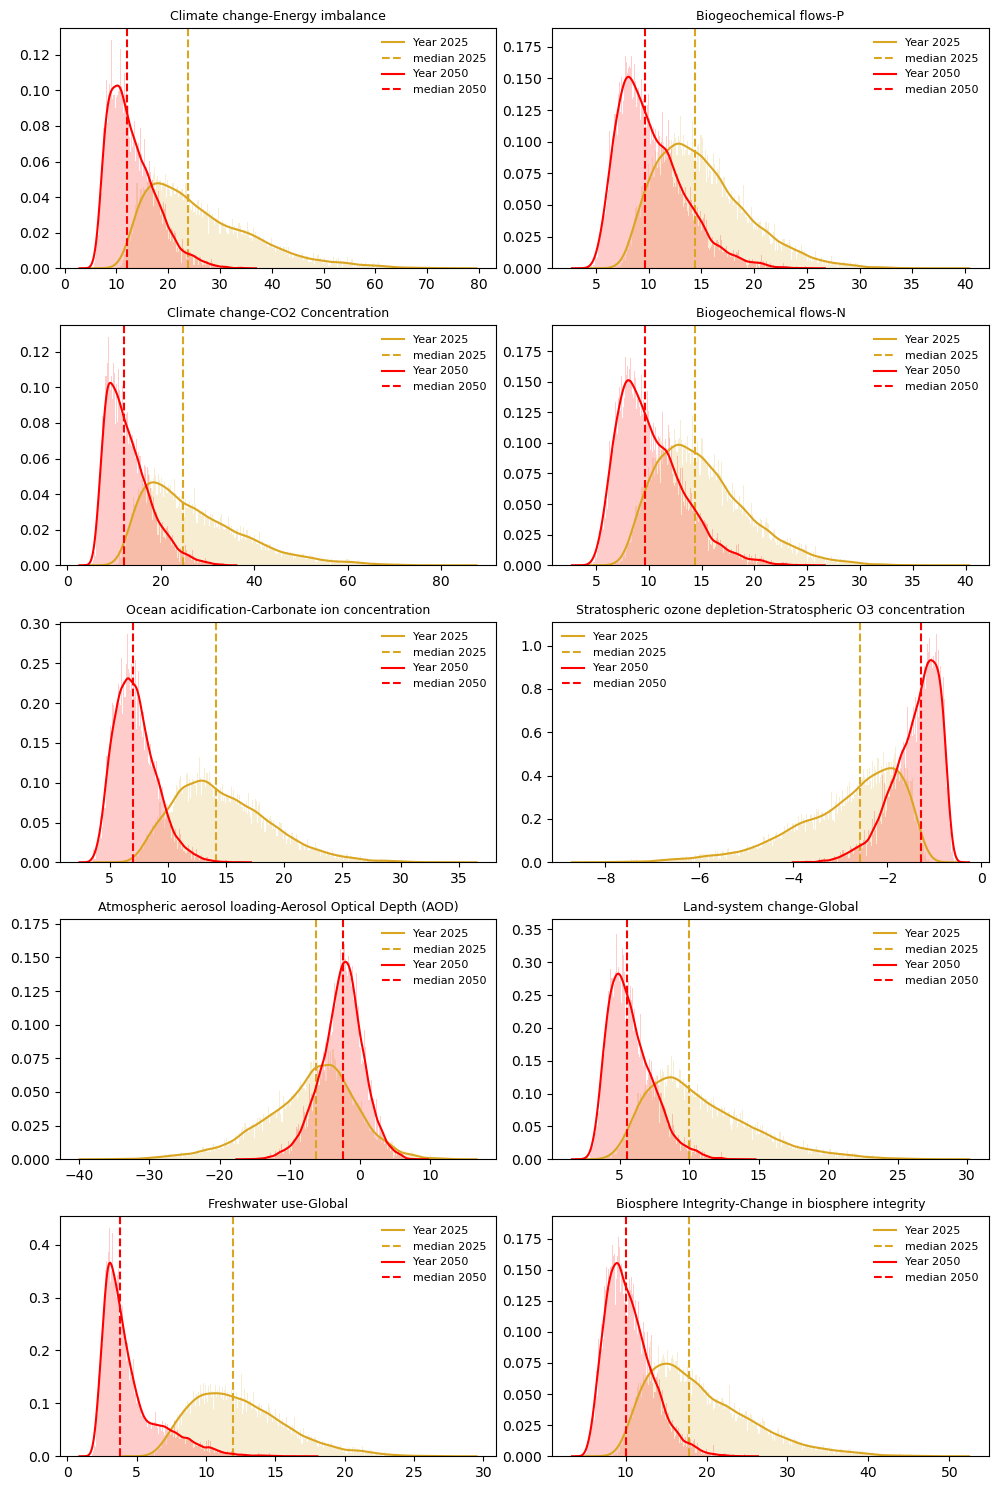

In [ ]:
using KernelDensity
cate=1
fig, axs = plt.subplots(5,2,figsize=(10,15))
for n in 1:2
    for y in 1:10
        colors=["goldenrod","red"]
        yrs=[2025,2050]
        axs[y].hist(x_res[y,:,n], bins=300,density=true, alpha=0.2, color=colors[n])
        kd = kde(x_res[y,:,n])
        axs[y].plot(kd.x, kd.density,label="Year $(yrs[n])",color=colors[n])
        axs[y].axvline(median(x_res[y,:,n]), linestyle="--", label="median $(yrs[n])",color=colors[n])
        axs[y].set_title(categories[y],fontsize=9)
        axs[y].legend(frameon=false, fontsize=8)
    end
end
fig.tight_layout()
display(plt.gcf())
plt.close("all")


Let's now evalute costs

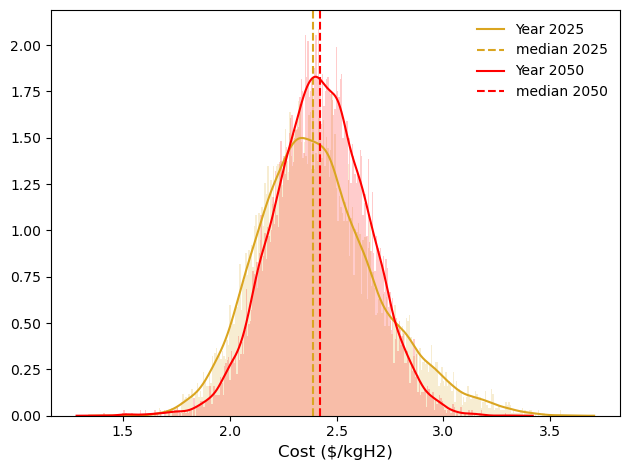

In [827]:
plt.figure()
for n in 1:2
    colors=["goldenrod","red"]
    yrs=[2025,2050]
    plt.hist(costs[:,n], bins=300,density=true, alpha=0.2,color=colors[n])
    p = kde(costs[:,n])
    plt.plot(p.x, p.density,label="Year $(yrs[n])",color=colors[n])
    plt.axvline(median(costs[:,n]), linestyle="--", label="median $(yrs[n])",color=colors[n])
end
plt.legend(frameon=false, fontsize=10)
plt.xlabel("Cost (\$/kgH2)",fontsize=12)
plt.tight_layout()
display(plt.gcf())
plt.close("all")


It is very low comared to the current cost of hydrogen production. It's important to remember that this is for demonstration only, we assumed/made up some costs. A more rigourous analysis might find much higher costs. 